In [37]:
import sys
import os

import json
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import Resize
import torch.nn.functional as F

from datasets import Dataset, Features, Value
from datasets import Image as HFImage
from transformers import AutoImageProcessor, AutoModel

# OADino embedding evaluation (from data.py outputs)
This section reproduces the attribute-level retrieval evaluation using the embeddings saved by `data.py`.

In [38]:
import itertools
import pickle
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DINOv2 ViT-S/14 + transforms (for completeness)
dino_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device).eval()
dino_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

def load_embedding_pair(single_dir, multi_dir):
    single_dir = Path(single_dir)
    multi_dir = Path(multi_dir)

    with open(single_dir / "single_embeddings.pkl", "rb") as f:
        single_emb = pickle.load(f)
    with open(single_dir / "single_metadata.pkl", "rb") as f:
        single_meta = pickle.load(f)

    with open(multi_dir / "multi_embeddings.pkl", "rb") as f:
        multi_emb = pickle.load(f)
    with open(multi_dir / "multi_metadata.pkl", "rb") as f:
        multi_meta = pickle.load(f)

    return single_emb, single_meta, multi_emb, multi_meta

def stack_dino(dino_list):
    return torch.stack([d if torch.is_tensor(d) else torch.tensor(d) for d in dino_list], dim=0)

def pool_latents(latents_list):
    pooled = []
    latent_dim = None
    for lat in latents_list:
        t = lat if torch.is_tensor(lat) else torch.tensor(lat)
        if latent_dim is None and t.numel() > 0:
            latent_dim = t.shape[1]
        if t.numel() == 0:
            pooled.append(torch.zeros(latent_dim if latent_dim else 1))
        else:
            pooled.append(t.mean(dim=0))
    return torch.stack(pooled, dim=0)

def get_coords(meta, idx):
    if "world_coords" in meta:
        return meta["world_coords"][idx]
    if "3d_coords" in meta:
        return meta["3d_coords"][idx]
    return None

def match_count_and_dist(query_meta, cand_meta, attr_keys):
    # query is single-object
    q_attrs = {k: query_meta[k][0] for k in attr_keys}
    q_coords = get_coords(query_meta, 0)
    n = cand_meta["num_objects"]
    matches = 0
    distances = []
    for i in range(n):
        ok = True
        for k in attr_keys:
            if cand_meta[k][i] != q_attrs[k]:
                ok = False
                break
        if ok:
            matches += 1
            c_coords = get_coords(cand_meta, i)
            if q_coords is not None and c_coords is not None:
                distances.append(float(np.linalg.norm(np.array(q_coords) - np.array(c_coords))))
    return matches, distances

def weighted_precision(matches):
    weights = np.array([1.0 / (i + 1) for i in range(len(matches))], dtype=np.float32)
    return float((weights * np.array(matches, dtype=np.float32)).sum() / weights.sum())

def evaluate_retrieval(query_feats, cand_feats, query_meta, cand_meta, topk=10, attr_keys=("color","shape","size","material"), filter_dataset=None):
    """
    Evaluate retrieval performance.
    
    Args:
        filter_dataset: If 'clevr' or 'clevrtex', only evaluate on queries from that dataset.
                       If None, evaluate on all queries.
    """
    q = F.normalize(query_feats, dim=1)
    c = F.normalize(cand_feats, dim=1)
    sims = q @ c.T
    topk = min(topk, cand_feats.shape[0])

    precisions = []
    w_precisions = []

    for i in range(sims.shape[0]):
        # Skip if filtering by dataset
        if filter_dataset is not None:
            query_dataset = query_meta[i].get("dataset", "").lower()
            if filter_dataset == "clevr" and "clevrtex" in query_dataset:
                continue
            elif filter_dataset == "clevrtex" and "clevrtex" not in query_dataset:
                continue
        
        idx = torch.topk(sims[i], k=topk).indices.tolist()
        matches = []
        for j in idx:
            count, distances = match_count_and_dist(query_meta[i], cand_meta[j], attr_keys)
            matches.append(count > 0)
        precisions.append(sum(matches) / topk)
        w_precisions.append(weighted_precision(matches))

    if len(precisions) == 0:
        return {
            "precision": 0.0,
            "wprecision": 0.0,
            "error_rate": 1.0,
        }

    precision = float(np.mean(precisions))
    return {
        "precision": precision,
        "wprecision": float(np.mean(w_precisions)),
        "error_rate": 1.0 - precision,
    }

def build_attr_subsets():
    mapping = {"C": "color", "D": "shape", "S": "size", "M": "material"}
    keys = list(mapping.keys())
    subsets = []
    for r in [1, 2, 3, 4]:
        for combo in itertools.permutations(keys, r):
            subset_name = "".join(combo)
            subset_keys = tuple(mapping[k] for k in combo)
            subsets.append((subset_name, subset_keys))
    return subsets

EMB_PATH = "C:/Users/maril/OneDrive/Desktop/GitHub/OADino/oadino/data/CLEVR_CLEVRTex_train_4K_224_VAE16_20260213_213522/embeddings"
single_emb, single_meta, multi_emb, multi_meta = load_embedding_pair(
    f"{EMB_PATH}/single_object",
    f"{EMB_PATH}/multi_object",
)

single_dino = stack_dino(single_emb["dino_cls"])
multi_dino = stack_dino(multi_emb["dino_cls"])
single_vae = pool_latents(single_emb["vae_latents"])
multi_vae = pool_latents(multi_emb["vae_latents"])
alpha = 40.0
single_combo = torch.cat([single_dino, alpha * single_vae], dim=1)
multi_combo = torch.cat([multi_dino, alpha * multi_vae], dim=1)

# Filter queries (single-object) and candidates (multi-object)
single_idx = [i for i, m in enumerate(single_meta) if m["num_objects"] == 1]
multi_idx = [i for i, m in enumerate(multi_meta) if m["num_objects"] > 1]

single_dino = single_dino[single_idx]
single_vae = single_vae[single_idx]
single_combo = single_combo[single_idx]
single_meta = [single_meta[i] for i in single_idx]

multi_dino = multi_dino[multi_idx]
multi_vae = multi_vae[multi_idx]
multi_combo = multi_combo[multi_idx]
multi_meta = [multi_meta[i] for i in multi_idx]

print("Loaded:", single_dino.shape, multi_dino.shape)

Using cache found in C:\Users\maril/.cache\torch\hub\facebookresearch_dinov2_main


Using cache found in C:\Users\maril/.cache\torch\hub\facebookresearch_dinov2_main


Loaded: torch.Size([602, 384]) torch.Size([9854, 384])


In [60]:
# Debug: Check dataset distribution in embeddings
clevr_count = sum(1 for m in multi_meta if m.get('dataset', '').lower() == 'clevr')
clevrtex_count = sum(1 for m in multi_meta if 'clevrtex' in m.get('dataset', '').lower())
print(f"Embeddings: {clevr_count} CLEVR, {clevrtex_count} CLEVRTex, {len(multi_meta)} total")

# Check order pattern
print("\nDataset pattern in first 20 embeddings:")
for i in range(min(20, len(multi_meta))):
    dataset = multi_meta[i].get('dataset', 'unknown')
    print(f"  {i}: {multi_meta["image_dir"]}")

Embeddings: 4857 CLEVR, 4997 CLEVRTex, 9854 total

Dataset pattern in first 20 embeddings:


TypeError: list indices must be integers or slices, not str

In [39]:
# Evaluate DINO-only, VAE-only, and DINO+VAE retrieval with sampling
topk = 10
full_keys = ("color", "shape", "size", "material")
num_runs = 7
num_queries = 50
rng = np.random.default_rng(42)

def sample_query_indices(n_total, n_samples):
    n_samples = min(n_samples, n_total)
    return rng.choice(n_total, size=n_samples, replace=False)

def run_sampled_eval(query_feats, cand_feats, query_meta, cand_meta, filter_dataset=None):
    metrics = []
    for _ in range(num_runs):
        idx = sample_query_indices(len(query_meta), num_queries)
        qf = query_feats[idx]
        qm = [query_meta[i] for i in idx]
        metrics.append(evaluate_retrieval(qf, cand_feats, qm, cand_meta, topk=topk, attr_keys=full_keys, filter_dataset=filter_dataset))
    return metrics

def summarize_metrics(metrics_list):
    keys = metrics_list[0].keys()
    out = {}
    for k in keys:
        vals = [m[k] for m in metrics_list]
        out[k] = {"mean": float(np.mean(vals)), "std": float(np.std(vals))}
    return out

# Evaluate on all queries (mixed CLEVR + CLEVRTex)
print("="*60)
print("OVERALL RESULTS (CLEVR + CLEVRTex mixed)")
print("="*60)
dino_metrics = run_sampled_eval(single_dino, multi_dino, single_meta, multi_meta)
vae_metrics = run_sampled_eval(single_vae, multi_vae, single_meta, multi_meta)
combo_metrics = run_sampled_eval(single_combo, multi_combo, single_meta, multi_meta)

print("\nDINO-only:", summarize_metrics(dino_metrics))
print("VAE-only:", summarize_metrics(vae_metrics))
print("DINO+VAE:", summarize_metrics(combo_metrics))

# Evaluate on CLEVR queries only
print("\n" + "="*60)
print("CLEVR ONLY")
print("="*60)
dino_clevr = run_sampled_eval(single_dino, multi_dino, single_meta, multi_meta, filter_dataset="clevr")
vae_clevr = run_sampled_eval(single_vae, multi_vae, single_meta, multi_meta, filter_dataset="clevr")
combo_clevr = run_sampled_eval(single_combo, multi_combo, single_meta, multi_meta, filter_dataset="clevr")

print("\nDINO-only:", summarize_metrics(dino_clevr))
print("VAE-only:", summarize_metrics(vae_clevr))
print("DINO+VAE:", summarize_metrics(combo_clevr))

# Evaluate on CLEVRTex queries only
print("\n" + "="*60)
print("CLEVRTex ONLY")
print("="*60)
dino_clevrtex = run_sampled_eval(single_dino, multi_dino, single_meta, multi_meta, filter_dataset="clevrtex")
vae_clevrtex = run_sampled_eval(single_vae, multi_vae, single_meta, multi_meta, filter_dataset="clevrtex")
combo_clevrtex = run_sampled_eval(single_combo, multi_combo, single_meta, multi_meta, filter_dataset="clevrtex")

print("\nDINO-only:", summarize_metrics(dino_clevrtex))
print("VAE-only:", summarize_metrics(vae_clevrtex))
print("DINO+VAE:", summarize_metrics(combo_clevrtex))

OVERALL RESULTS (CLEVR + CLEVRTex mixed)

DINO-only: {'precision': {'mean': 0.01742857142857143, 'std': 0.007537660547584525}, 'wprecision': {'mean': 0.01577447812472071, 'std': 0.006823679661646117}, 'error_rate': {'mean': 0.9825714285714285, 'std': 0.007537660547584532}}
VAE-only: {'precision': {'mean': 0.027142857142857142, 'std': 0.007239348262468531}, 'wprecision': {'mean': 0.03089941195079259, 'std': 0.007531936453706422}, 'error_rate': {'mean': 0.972857142857143, 'std': 0.007239348262468537}}
DINO+VAE: {'precision': {'mean': 0.036, 'std': 0.00931971796017148}, 'wprecision': {'mean': 0.039410840091960775, 'std': 0.011894852017608735}, 'error_rate': {'mean': 0.9639999999999999, 'std': 0.009319717960171489}}

CLEVR ONLY

DINO-only: {'precision': {'mean': 0.09011733880154933, 'std': 0.028245600572592858}, 'wprecision': {'mean': 0.07693215057139736, 'std': 0.02885342569129221}, 'error_rate': {'mean': 0.9098826611984506, 'std': 0.028245600572592865}}
VAE-only: {'precision': {'mean': 0

In [40]:
# Attribute ablation for DINO-only, VAE-only, DINO+VAE (sampled queries)
subsets = build_attr_subsets()
results = {"overall": {"dino": {}, "vae": {}, "combo": {}}, 
           "clevr": {"dino": {}, "vae": {}, "combo": {}},
           "clevrtex": {"dino": {}, "vae": {}, "combo": {}}}

def run_sampled_ablation(query_feats, cand_feats, query_meta, cand_meta, filter_dataset=None):
    ablation_metrics = {}
    for name, keys in subsets:
        per_run = []
        for _ in range(num_runs):
            idx = sample_query_indices(len(query_meta), num_queries)
            qf = query_feats[idx]
            qm = [query_meta[i] for i in idx]
            per_run.append(evaluate_retrieval(qf, cand_feats, qm, cand_meta, topk=topk, attr_keys=keys, filter_dataset=filter_dataset))
        # store mean/std for this subset
        ablation_metrics[name] = {
            "precision": {"mean": float(np.mean([m["precision"] for m in per_run])), "std": float(np.std([m["precision"] for m in per_run]))},
            "wprecision": {"mean": float(np.mean([m["wprecision"] for m in per_run])), "std": float(np.std([m["wprecision"] for m in per_run]))},
            "error_rate": {"mean": float(np.mean([m["error_rate"] for m in per_run])), "std": float(np.std([m["error_rate"] for m in per_run]))},
        }
    return ablation_metrics

# Run ablation on all queries (Overall)
results["overall"]["dino"] = run_sampled_ablation(single_dino, multi_dino, single_meta, multi_meta)
results["overall"]["vae"] = run_sampled_ablation(single_vae, multi_vae, single_meta, multi_meta)
results["overall"]["combo"] = run_sampled_ablation(single_combo, multi_combo, single_meta, multi_meta)

# Run ablation on CLEVR queries only
results["clevr"]["dino"] = run_sampled_ablation(single_dino, multi_dino, single_meta, multi_meta, filter_dataset="clevr")
results["clevr"]["vae"] = run_sampled_ablation(single_vae, multi_vae, single_meta, multi_meta, filter_dataset="clevr")
results["clevr"]["combo"] = run_sampled_ablation(single_combo, multi_combo, single_meta, multi_meta, filter_dataset="clevr")

# Run ablation on CLEVRTex queries only
results["clevrtex"]["dino"] = run_sampled_ablation(single_dino, multi_dino, single_meta, multi_meta, filter_dataset="clevrtex")
results["clevrtex"]["vae"] = run_sampled_ablation(single_vae, multi_vae, single_meta, multi_meta, filter_dataset="clevrtex")
results["clevrtex"]["combo"] = run_sampled_ablation(single_combo, multi_combo, single_meta, multi_meta, filter_dataset="clevrtex")

def summarize(results_dict):
    length_groups = {1: [], 2: [], 3: [], 4: []}
    for name, metrics in results_dict.items():
        length_groups[len(name)].append(metrics["precision"]["mean"])
    means = {k: float(np.mean(v)) for k, v in length_groups.items() if len(v) > 0}
    stds = {k: float(np.std(v)) for k, v in length_groups.items() if len(v) > 0}
    return means, stds

def ablation_removed_attributes(results_dict):
    full = set(["C", "D", "S", "M"])
    removed = {}
    for name in results_dict.keys():
        removed[name] = "".join(sorted(full - set(name)))
    return removed

def single_attribute_ablation(results_dict):
    removed_map = {"C": "color", "D": "shape", "S": "size", "M": "material"}
    out = {}
    for rem_key in ["C", "D", "S", "M"]:
        filtered = {k: v for k, v in results_dict.items() if rem_key not in k}
        out[removed_map[rem_key]] = {
            "mean": float(np.mean([v["precision"]["mean"] for v in filtered.values()])),
            "std": float(np.std([v["precision"]["mean"] for v in filtered.values()])),
        }
    return out

# Print results for all dataset splits
for dataset_name in ["overall", "clevr", "clevrtex"]:
    print("\n" + "="*60)
    print(f"ABLATION SUMMARY: {dataset_name.upper()}")
    print("="*60)
    for model_name in ["dino", "vae", "combo"]:
        means, stds = summarize(results[dataset_name][model_name])
        removed = ablation_removed_attributes(results[dataset_name][model_name])
        single_removals = single_attribute_ablation(results[dataset_name][model_name])
        print("\n", model_name.upper(), "ablation")
        print("mean precision by length:", means)
        print("std precision by length:", stds)
        print("removed attributes per subset (C/D/S/M removed):", list(removed.items())[:10])
        print("single-attribute ablation (remove one at a time):", single_removals)


ABLATION SUMMARY: OVERALL

 DINO ablation
mean precision by length: {1: 0.5776428571428571, 2: 0.20678571428571427, 3: 0.05979761904761905, 4: 0.020226190476190477}
std precision by length: {1: 0.24487834338957887, 2: 0.11515532988099161, 3: 0.026739926473355408, 4: 0.002604260202401837}
removed attributes per subset (C/D/S/M removed): [('C', 'DMS'), ('D', 'CMS'), ('S', 'CDM'), ('M', 'CDS'), ('CD', 'MS'), ('CS', 'DM'), ('CM', 'DS'), ('DC', 'MS'), ('DS', 'CM'), ('DM', 'CS')]
single-attribute ablation (remove one at a time): {'color': {'mean': 0.2611047619047619, 'std': 0.23902065186535784}, 'shape': {'mean': 0.17691428571428572, 'std': 0.21267596507938782}, 'size': {'mean': 0.16702857142857142, 'std': 0.20096755889419354}, 'material': {'mean': 0.2836, 'std': 0.24669120966335642}}

 VAE ablation
mean precision by length: {1: 0.6203571428571428, 2: 0.2234285714285714, 3: 0.0739047619047619, 4: 0.029440476190476194}
std precision by length: {1: 0.28254285389249234, 2: 0.12431302381953574,

In [64]:
# Retrieval visualization
import matplotlib.pyplot as plt
from PIL import Image

def load_clevr_image_paths(image_dir, scenes_json, keep_single, max_images=None):
    """Load CLEVR-style dataset with single scenes.json file"""
    image_dir = Path(image_dir)
    scenes_json = Path(scenes_json)
    with open(scenes_json, "r", encoding="utf-8") as f:
        data = json.load(f)
    scenes = data.get("scenes", [])
    paths = []
    for scene in scenes:
        objects = scene.get("objects", [])
        is_single = len(objects) == 1
        if keep_single != is_single:
            continue
        filename = scene.get("image_filename")
        if filename is None:
            image_index = scene.get("image_index")
            split = scene.get("split", "val")
            if image_index is None:
                continue
            filename = f"CLEVR_{split}_{image_index:06d}.png"
        path = image_dir / filename
        if path.exists():
            paths.append(path)
        if max_images is not None and len(paths) >= max_images:
            break
    return paths

def load_clevrtex_image_paths(image_dir, keep_single, max_images=None):
    """Load CLEVRTex-style dataset with per-image JSON files"""
    image_dir = Path(image_dir)
    paths = []
    
    # Find all PNG files
    image_files = sorted(image_dir.glob("*.png"))
    
    for image_path in image_files:
        # Corresponding JSON file has the same name
        json_path = image_path.with_suffix(".json")
        
        if not json_path.exists():
            continue
            
        try:
            with open(json_path, "r", encoding="utf-8") as f:
                scene_data = json.load(f)
        except Exception as e:
            print(f"Warning: Failed to load {json_path}: {e}")
            continue
            
        objects = scene_data.get("objects", [])
        is_single = len(objects) == 1
        if keep_single != is_single:
            continue
            
        paths.append(image_path)
        
        if max_images is not None and len(paths) >= max_images:
            break
            
    return paths

def load_image_paths_from_sources(sources, keep_single):
    """Load image paths from multiple sources (CLEVR and/or CLEVRTex)"""
    all_paths = []
    
    for src in sources:
        image_dir = src["image_dir"]
        use_per_image_json = src.get("use_per_image_json", False)
        max_images = src.get("max_images")
        
        if use_per_image_json or "scenes_json" not in src:
            # CLEVRTex-style: per-image JSON files
            paths = load_clevrtex_image_paths(image_dir, keep_single, max_images)
        else:
            # CLEVR-style: single scenes.json file
            scenes_json = src["scenes_json"]
            paths = load_clevr_image_paths(image_dir, scenes_json, keep_single, max_images)
        
        all_paths.extend(paths)
    
    return all_paths

# Define sources for both single and multi-object images
DATASET_PATH = "C:/Users/maril/OneDrive/Desktop/GitHub/OADino/oadino/dataset"

single_sources = [
    {
        "image_dir": Path(DATASET_PATH + "/single/images_single"),
        "scenes_json": Path(DATASET_PATH + "/single/CLEVR_single_scenes.json"),
        "dataset_name": "clevr",
    },
    {
        "image_dir": Path(DATASET_PATH + "/single/CLEVRTex_single/clevrtex_single/0"),
        "use_per_image_json": True,
        "dataset_name": "clevrtex",
    }
]

multi_sources = [
    {
        "image_dir": Path(DATASET_PATH + "/multi/CLEVR_v1.0/images/val"),  
        "scenes_json": Path(DATASET_PATH + "/multi/CLEVR_v1.0/scenes/CLEVR_val_scenes.json"),
        "dataset_name": "clevr",
    },
    {
        "image_dir": Path(DATASET_PATH + "/multi/clevrtex_full/0"),
        "use_per_image_json": True,
        "dataset_name": "clevrtex",
    }
]

single_paths = load_image_paths_from_sources(single_sources, keep_single=True)

# Load multi_paths in the SAME ORDER as multi_meta
# First load all CLEVR, then all CLEVRTex
clevr_paths_all = []
clevrtex_paths_all = []

for src in multi_sources:
    if src["dataset_name"] == "clevr":
        clevr_paths_all = load_clevr_image_paths(
            src["image_dir"], 
            src["scenes_json"], 
            keep_single=False, 
            max_images=None
        )
    elif src["dataset_name"] == "clevrtex":
        clevrtex_paths_all = load_clevrtex_image_paths(
            src["image_dir"], 
            keep_single=False, 
            max_images=None
        )

# Reconstruct multi_paths in the same order as multi_meta
multi_paths = []
clevr_idx = 0
clevrtex_idx = 0

for meta in multi_meta:
    dataset = meta.get('dataset', '').lower()
    if 'clevrtex' in dataset:
        if clevrtex_idx < len(clevrtex_paths_all):
            multi_paths.append(clevrtex_paths_all[clevrtex_idx])
            clevrtex_idx += 1
    else:  # CLEVR
        if clevr_idx < len(clevr_paths_all):
            multi_paths.append(clevr_paths_all[clevr_idx])
            clevr_idx += 1

print(f"Loaded {len(single_paths)} single-object images and {len(multi_paths)} multi-object images")
print(f"  CLEVR: {clevr_idx} used, CLEVRTex: {clevrtex_idx} used")

def retrieve_indices(query_idx, topk=8, mode="combo"):
    if mode == "dino":
        q = single_dino
        c = multi_dino
    elif mode == "vae":
        q = single_vae
        c = multi_vae
    else:
        q = single_combo
        c = multi_combo
    sims = F.normalize(q, dim=1) @ F.normalize(c, dim=1).T
    topk = min(topk, c.shape[0])
    return torch.topk(sims[query_idx], k=topk).indices.tolist()

def show_retrieval(query_idx=0, topk=8, mode="combo"):
    # Check if query_idx is valid
    if query_idx >= len(single_paths):
        print(f"Warning: query_idx {query_idx} >= {len(single_paths)} available single images")
        print(f"Using query_idx=0 instead")
        query_idx = 0
    
    idxs = retrieve_indices(query_idx, topk=topk, mode=mode)
    
    # Filter out invalid candidate indices
    valid_idxs = [(i, j) for i, j in enumerate(idxs, start=1) if j < len(multi_paths)]
    if len(valid_idxs) < len(idxs):
        print(f"Warning: Only {len(valid_idxs)}/{len(idxs)} retrieved candidates have image paths available")
    
    if len(valid_idxs) == 0:
        print("Error: No valid candidates to display")
        return
    
    fig, axes = plt.subplots(1, len(valid_idxs) + 1, figsize=(2 * (len(valid_idxs) + 1), 3))
    
    # Query image
    q_path = single_paths[query_idx]
    axes[0].imshow(Image.open(q_path))
    axes[0].set_title("query")
    axes[0].axis("off")
    
    # Retrieved candidates (only valid ones)
    for idx, (i, j) in enumerate(valid_idxs, start=1):
        c_path = multi_paths[j]
        axes[idx].imshow(Image.open(c_path))
        axes[idx].set_title(f"rank {i}")
        axes[idx].axis("off")
    
    plt.tight_layout()
    plt.show()

Loaded 1020 single-object images and 9854 multi-object images
  CLEVR: 4857 used, CLEVRTex: 4997 used


CLEVR query (simple objects):


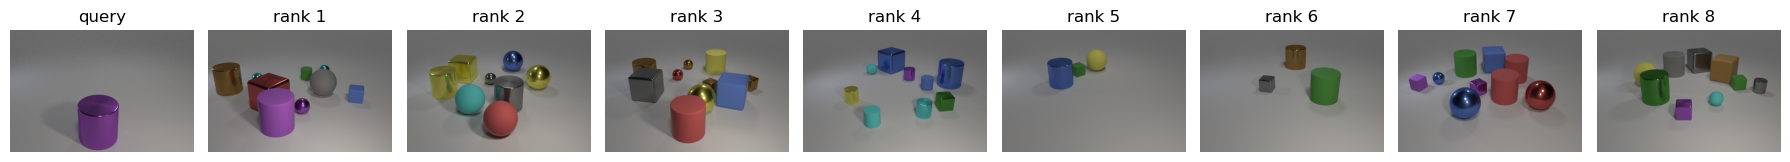

In [70]:
# Example: CLEVR query
print("CLEVR query (simple objects):")
show_retrieval(query_idx=10, topk=8, mode="combo")

CLEVR query (simple objects):


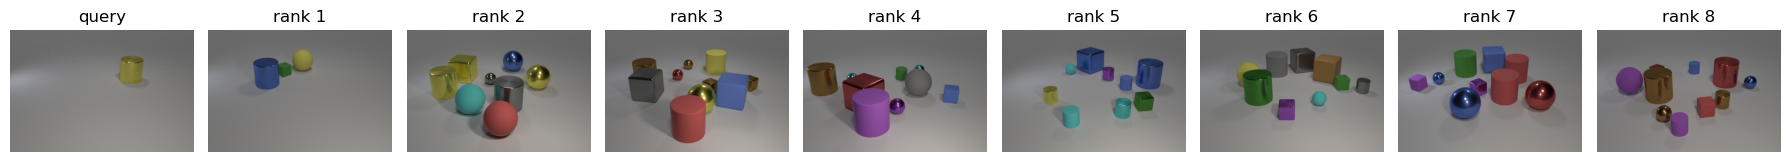

In [79]:
# Example: CLEVR query
print("CLEVR query (simple objects):")
show_retrieval(query_idx=15, topk=8, mode="combo")


CLEVRTex query (textured objects):


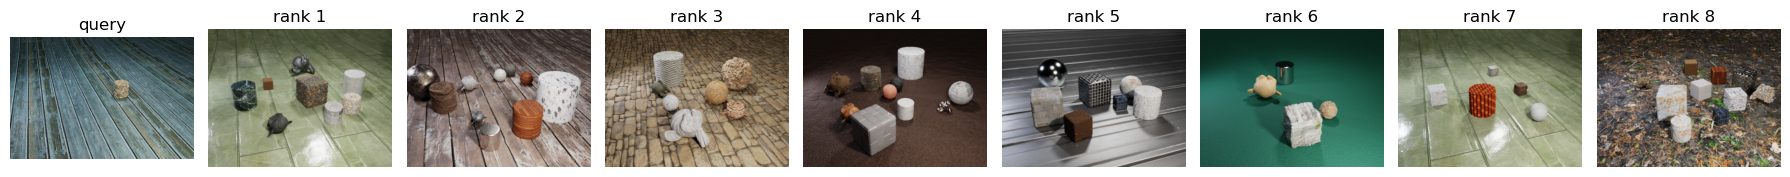

In [71]:
# Example: CLEVRTex query (textured objects)
print("\nCLEVRTex query (textured objects):")
show_retrieval(query_idx=550, topk=8, mode="combo")


CLEVRTex query (textured objects):


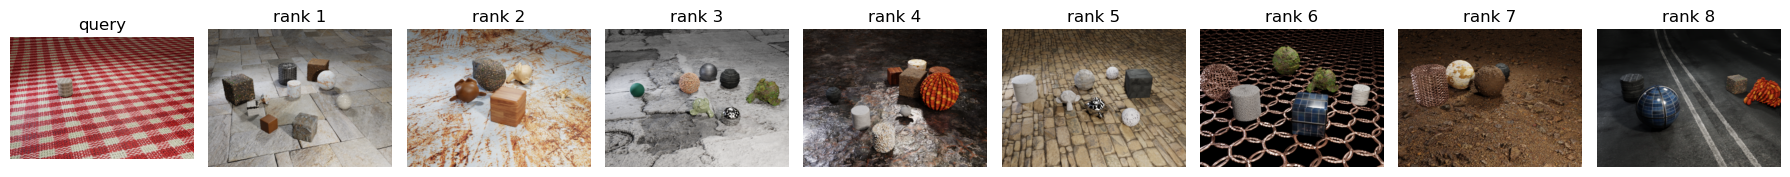

In [78]:
# Example: CLEVRTex query (textured objects)
print("\nCLEVRTex query (textured objects):")
show_retrieval(query_idx=580, topk=8, mode="combo")